<a href="https://colab.research.google.com/github/kerserbibk/lstm-stock-forecast-/blob/main/stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import io
import os
from google.colab import files

In [42]:
look_back = 30 # best at 30-45
layer_size = 50
lr = 0.006
epochs = 200
num_layers = 1

In [43]:
df = pd.read_csv('stocks.csv')

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-05 00:00:00-04:00,6.730000,7.140000,6.590000,6.890000,16916400.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-05 00:00:00-04:00,99.000000,102.050003,98.760002,100.589996,41181000.0,0.0,0.0,amd,AMD,technology,usa,NaN
2,2025-05-05 00:00:00-04:00,118.389999,118.540001,116.650002,117.199997,47600.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
3,2025-05-05 00:00:00-04:00,275.459991,281.589996,274.079987,278.029999,2416300.0,0.0,0.0,american express,AXP,finance,usa,NaN
4,2025-05-05 00:00:00-04:00,27.278000,27.278000,27.278000,27.278000,100.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN


In [44]:
df = df[['Date','Close','Ticker']]
df.head()

,Date,Close,Ticker
0,2025-05-05 00:00:00-04:00,6.890000,PTON
1,2025-05-05 00:00:00-04:00,100.589996,AMD
2,2025-05-05 00:00:00-04:00,117.199997,ADDYY
3,2025-05-05 00:00:00-04:00,278.029999,AXP
4,2025-05-05 00:00:00-04:00,27.278000,PMMAF


In [46]:
#converting string to datetime
import datetime as dt
df['Date'] = pd.to_datetime(df['Date'])
df.head()

<ipython-input-46-6e0c9924a719>:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Close,Ticker
0,2025-05-05 00:00:00-04:00,6.890000,PTON
1,2025-05-05 00:00:00-04:00,100.589996,AMD
2,2025-05-05 00:00:00-04:00,117.199997,ADDYY
3,2025-05-05 00:00:00-04:00,278.029999,AXP
4,2025-05-05 00:00:00-04:00,27.278000,PMMAF


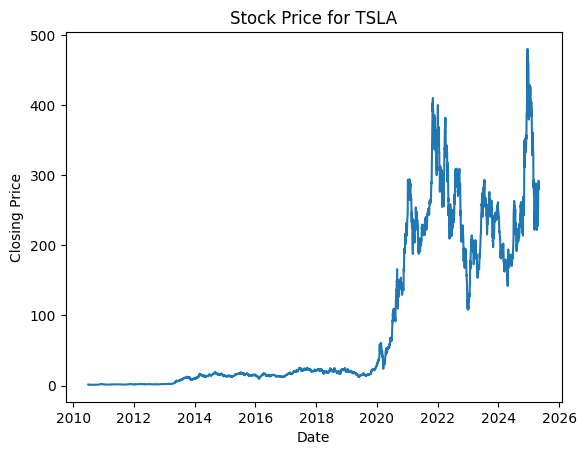

In [47]:
# --- Filter data for the specific ticker ---
ticker_to_plot = 'TSLA'  # Replace with the desired ticker symbol
filtered_df = df[df['Ticker'] == ticker_to_plot]

# --- Plot the data for the filtered ticker ---
plt.plot(filtered_df['Date'], filtered_df['Close'])
plt.title(f'Stock Price for {ticker_to_plot}')  # Add a title to the plot
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [48]:
def create_dataset(data, lookback=look_back):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])  # next day
    return np.array(X), np.array(y)

# 'Close'
close_prices = filtered_df[['Close']].values

# normalization(0,1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(close_prices)

# X and y
X, y = create_dataset(close_prices, lookback=look_back)

X.shape

(3757, 30)

In [52]:
# turning data to 3d shape
X_reshaped = np.reshape(X, (X.shape[0], X.shape[1], 1))

# to tensor
X_tensor = torch.Tensor(X_reshaped)
y_tensor = torch.Tensor(y)

# splitting train test
train_size = int(len(X_tensor) * 0.8)
X_train_tensor, X_test_tensor = X_tensor[:train_size], X_tensor[train_size:]
y_train_tensor, y_test_tensor = y_tensor[:train_size], y_tensor[train_size:]

In [53]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=layer_size, output_size=1):
        super(LSTMModel, self).__init__()

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers ,batch_first=True)

        #attention layer
        self.attention = nn.MultiheadAttention(embed_dim=layer_size, num_heads=1, batch_first=True)

        # output layer (Dense layer)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        context, weights = self.attention(lstm_out, lstm_out, lstm_out)

        predictions = self.linear(lstm_out[:, -1, :])

        return predictions,weights

# define model
model = LSTMModel(input_size=1, hidden_layer_size=layer_size, output_size=1)

# define loss
criterion = nn.MSELoss()

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [54]:
#train
for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()
    y_pred,_ = model(X_train_tensor)

    # calculate loss
    loss = criterion(y_pred, y_train_tensor.view(-1, 1))

    # backpropogation
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/200, Loss: 25920.2949
Epoch 2/200, Loss: 25871.8906
Epoch 3/200, Loss: 25836.6875
Epoch 4/200, Loss: 25796.7539
Epoch 5/200, Loss: 25747.7832
Epoch 6/200, Loss: 25703.5723
Epoch 7/200, Loss: 25678.3711
Epoch 8/200, Loss: 25655.3828
Epoch 9/200, Loss: 25629.0742
Epoch 10/200, Loss: 25596.5977
Epoch 11/200, Loss: 25533.4727
Epoch 12/200, Loss: 25485.7051
Epoch 13/200, Loss: 25426.9941
Epoch 14/200, Loss: 25355.6074
Epoch 15/200, Loss: 25288.0195
Epoch 16/200, Loss: 25231.9902
Epoch 17/200, Loss: 25175.9844
Epoch 18/200, Loss: 25113.4297
Epoch 19/200, Loss: 25038.2461
Epoch 20/200, Loss: 24946.7520
Epoch 21/200, Loss: 24854.6777
Epoch 22/200, Loss: 24782.7812
Epoch 23/200, Loss: 24726.5547
Epoch 24/200, Loss: 24669.3672
Epoch 25/200, Loss: 24612.8711
Epoch 26/200, Loss: 24561.1426
Epoch 27/200, Loss: 24511.0098
Epoch 28/200, Loss: 24453.8379
Epoch 29/200, Loss: 24389.3945
Epoch 30/200, Loss: 24319.4492
Epoch 31/200, Loss: 24244.2012
Epoch 32/200, Loss: 24163.3672
Epoch 33/200, Los

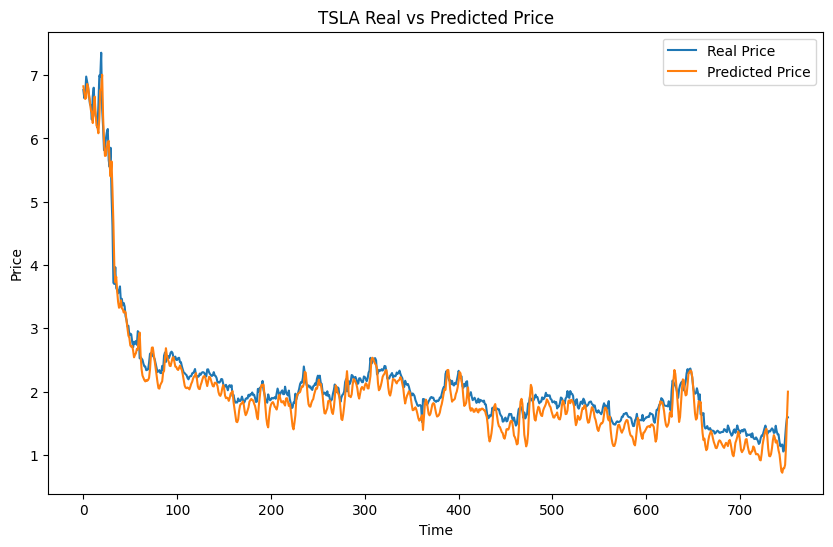

In [55]:
model.eval()

# Prediction
with torch.no_grad():
    predictions , weights = model(X_test_tensor)


# Visualize
plt.figure(figsize=(10,6))
plt.plot(y_test_tensor.numpy(), label='Real Price')
plt.plot(predictions.numpy(), label='Predicted Price')
plt.title(f'{ticker_to_plot} Real vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
last_lookback_days = X_test_tensor[-1].unsqueeze(0)

with torch.no_grad():
    next_day_prediction = model(last_lookback_days)

# normalize predictoin
next_day_prediction = scaler.inverse_transform(next_day_prediction.numpy())

# decide which
last_day_price = close_prices[-1]
if next_day_prediction[0][0] > last_day_price[0]:
    print("Predict: Increase")
else:
    print("Predict: Decrease")

Predict: Increase
